In [11]:
from qnet_context import qnetvo as qnet
from mac_context import multiple_access_channels as mac
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import isfile, join
import re

# Loading Data


In [3]:
def get_data_files(path, regex):
    """Retrieves all data files that match the ``regex`` in the
    directory specified by ``path``.
    """
    return [
        join(path, f)
        for f in listdir(path)
        if (f.endswith(".json") and isfile(join(path, f)) and bool(re.match(regex, f)))
    ]

def get_inequality_opt_dicts(path, mac_reg):

    and_tag = r"and_"
    xor_tag = r"xor_"

    inequality_xor_opt_dicts = []
    inequality_and_opt_dicts = []

    for i in range(20):
        inequality_tag = "I_fp_" if i == 0 else "I_" + str(i) + "_"
        
        xor_regex = mac_reg + inequality_tag + xor_tag + r".*"    
        xor_files = get_data_files(path, xor_regex)
        inequality_xor_opt_dicts += [[qnet.read_optimization_json(file) for file in xor_files]]
        
        and_regex = mac_reg + inequality_tag + and_tag + r".*"    
        and_files = get_data_files(path, and_regex)
        inequality_and_opt_dicts += [[qnet.read_optimization_json(file) for file in and_files]]


    return inequality_xor_opt_dicts, inequality_and_opt_dicts

def get_sig_dim_opt_dicts(path, regex):

    inequality_opt_dicts = []

    for i in range(8):
        inequalilty_tag = "I_" + str(i) + "_"
        files = get_data_files(path, regex + inequalilty_tag + r".*")
        inequality_opt_dicts += [[qnet.read_optimization_json(file) for file in files]]
    
    return inequality_opt_dicts

## Mac Data Analysis

In [4]:
data_path = "../data/bisender_mac_quantum_violations/"

qmac_xor_opt_dicts, qmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^qmac_")
ea_mac_xor_opt_dicts, ea_mac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ea_mac_")
ea_qmac_xor_opt_dicts, ea_qmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ea_qmac_")
ghza_cmac_xor_opt_dicts, ghza_cmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ghza_cmac_")
ghza_qmac_xor_opt_dicts, ghza_qmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ghza_qmac_")
ea3_cmac_xor_opt_dicts, ea3_cmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ea3_cmac_")
ea3_qmac_xor_opt_dicts, ea3_qmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ea3_qmac_")
ea_txrx_cmac_xor_opt_dicts, ea_txrx_cmac_and_opt_dicts = get_inequality_opt_dicts(data_path, r"^ea_txrx_cmac_")
ghza_cmac_no_locc_xor_opt_dicts, ghza_cmac_no_locc_xor_opt_dicts = get_inequality_opt_dicts(data_path, r"^ghza_cmac_no_locc_")

## Analyzing Data

In [5]:
def analyze_data(inequality_opt_dicts):
    fp_classical_bound = 7

    classical_bounds = [fp_classical_bound]
    classical_bounds += [inequality_tuple[0] for inequality_tuple in mac.bisender_mac_bounds()]

    qbounds = quantum_bounds()

    max_violations = []
    for i in range(20):
        max_violations += [
            (max([max(opt_dict["scores"]) for opt_dict in inequality_opt_dicts[i]]) - classical_bounds[i])/qbounds[i]
        ]

    return max_violations

def quantum_bounds():
    inequalities = mac.bisender_mac_bounds()
    fp_bound = 2
    quantum_bounds = [fp_bound]
    for ineq in inequalities:
        G = ineq[1]

        qbound = 0.0
        for i in range(9):
            qbound += max(G[:,i])
        
        quantum_bounds += [float(qbound) - ineq[0]]
    
    return quantum_bounds

def white_noise_scores():
    inequalities = mac.bisender_mac_bounds()

    fp_wn_score = 9/2 - 7
    wn_scores = [fp_wn_score]
    for ineq in inequalities:
        G = ineq[1]
        wn_score = np.sum(np.array(G)) / 2 - ineq[0]

        wn_scores += [wn_score]
    
    return wn_scores

def mac_critical_params(max_violations):
    wn_scores = white_noise_scores()
    qbounds = quantum_bounds()

    critical_params = []
    for i in range(20):
        gamma = max_violations[i] / (max_violations[i] - wn_scores[i] / qbounds[i])
        critical_params += [gamma]

    return critical_params


qmac_xor_max_violations = analyze_data(qmac_xor_opt_dicts)
qmac_and_max_violations = analyze_data(qmac_and_opt_dicts)
ea_mac_xor_max_violations = analyze_data(ea_mac_xor_opt_dicts)
ea_mac_and_max_violations = analyze_data(ea_mac_and_opt_dicts)
ea_qmac_xor_max_violations = analyze_data(ea_qmac_xor_opt_dicts)
ea_qmac_and_max_violations = analyze_data(ea_qmac_and_opt_dicts)

ea3_cmac_xor_max_violations = analyze_data(ea3_cmac_xor_opt_dicts)
ghza_cmac_xor_max_violations = analyze_data(ghza_cmac_xor_opt_dicts)

ea_txrx_xor_max_violations = analyze_data(ea_txrx_cmac_xor_opt_dicts)

ghza_qmac_xor_max_violations = analyze_data(ghza_qmac_xor_opt_dicts)
ea3_qmac_xor_max_violations = analyze_data(ea3_qmac_xor_opt_dicts)

ghza_cmac_no_locc_xor_max_violations = analyze_data(ghza_cmac_no_locc_xor_opt_dicts)

In [6]:
inequalities = mac.bisender_mac_bounds()

fp_wn_score = 9/2 - 7
wn_scores = [fp_wn_score]
for ineq in inequalities:
    G = ineq[1]
    wn_score = np.sum(G) / 2 - ineq[0]

    wn_scores += [wn_score]

np.sum(inequalities[0][1]) / 2 - inequalities[0][0]

tensor(-1.5, requires_grad=True)

In [7]:
quantum_bounds()

# white_noise_scores()

[2,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 5.0,
 5.0]

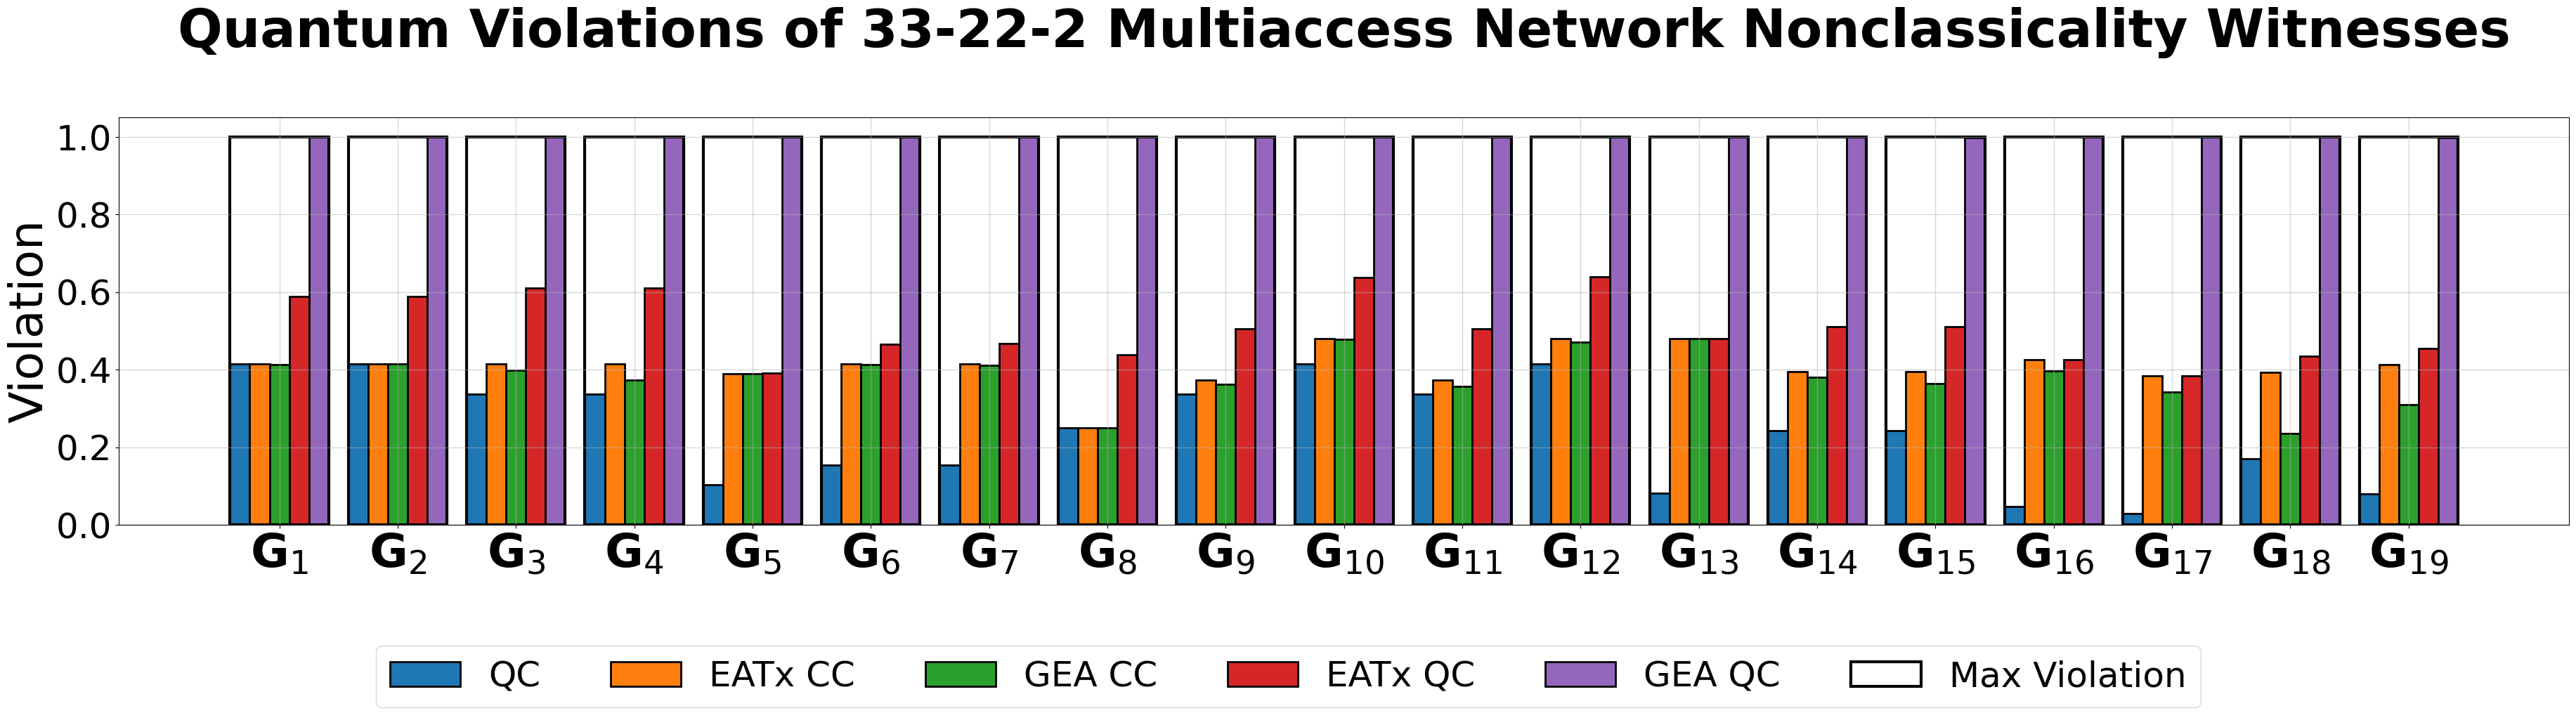

In [8]:
x_labels = [
    # r"$\mathbf{G}_{FP}$",
    r"$\mathbf{G}_1$", r"$\mathbf{G}_2$",r"$\mathbf{G}_3$", r"$\mathbf{G}_4$", r"$\mathbf{G}_5$", r"$\mathbf{G}_6$", r"$\mathbf{G}_7$", r"$\mathbf{G}_8$", r"$\mathbf{G}_9$", r"$\mathbf{G}_{10}$",
    r"$\mathbf{G}_{11}$", r"$\mathbf{G}_{12}$",r"$\mathbf{G}_{13}$", r"$\mathbf{G}_{14}$", r"$\mathbf{G}_{15}$", r"$\mathbf{G}_{16}$", r"$\mathbf{G}_{17}$", r"$\mathbf{G}_{18}$", r"$\mathbf{G}_{19}$",
]

x_axis = np.arange(19)

width = 1/6

fig = plt.figure(figsize=(45, 10))
plt.grid(linewidth=1, alpha=0.5)


plt.bar(x_axis-2*width, qmac_xor_max_violations[1:], width=width, label="QC", edgecolor="black",linewidth=2)
plt.bar(x_axis-1*width, ea_mac_xor_max_violations[1:], width=width, label="EATx CC", edgecolor="black", linewidth=2)
plt.bar(x_axis+0*width, ea3_cmac_xor_max_violations[1:], width=width, label="GEA CC", edgecolor="black", linewidth=2)
plt.bar(x_axis+1*width, ea_qmac_xor_max_violations[1:], width=width, label="EATx QC", edgecolor="black", linewidth=2)

# plt.bar(x_axis+3*width, ghza_qmac_xor_max_violations, width=width, label="GHZA QMAC", edgecolor="black", linewidth=2)
# plt.bar(x_axis+4*width, ea_txrx_xor_max_violations, width=width, label="EA TxRx CMAC", edgecolor="black", linewidth=2)
plt.bar(x_axis+2*width, ea3_qmac_xor_max_violations[1:], width=width, label="GEA QC", edgecolor="black", linewidth=2)
# plt.bar(x_axis+6*width, ghza_cmac_xor_max_violations, width=width, label="GHZA CMAC", edgecolor="black", linewidth=2)
# plt.bar(x_axis+7*width, ghza_cmac_no_locc_xor_max_violations, width=width, label="GHZA CMAC No LOCC", edgecolor="black", linewidth=2)




# plt.bar(x_axis+1*width, quantum_bounds(), width=1-width,  label="Violation Bound", edgecolor="black", linewidth=3, fill=False)
plt.bar(x_axis+0*width, np.ones(19), width=1-width,  label="Max Violation", edgecolor="black", linewidth=3, fill=False)





plt.xticks(x_axis, x_labels, fontsize=48)
plt.title("Quantum Violations of 33-22-2 Multiaccess Network Nonclassicality Witnesses\n", size=54, fontweight="bold")
plt.yticks(fontsize=36)
plt.ylabel("Violation", fontsize=48)
# plt.legend(fontsize=20, ncol=3)

plt.figlegend(loc="lower center", ncols = 6, fontsize=36)
plt.subplots_adjust(bottom=0.3)

plt.show()

In [9]:
def max_violation_table(
    configuration_names,
    qc_max_violations,
    eatx_cc_max_violations,
    gea_cc_max_violations,
    eatx_qc_max_violations,
    gea_qc_max_violations,
    game_names,
    cbounds,
    max_violations,
):
    table = [["Configuration \ Facets"] + game_names]
    for i, configuration_name in enumerate(configuration_names):
        table += [[configuration_name]]
        for j, game_name in enumerate(game_names):
            
            cbound = 0
            _violation = 

SyntaxError: invalid syntax (4225619063.py, line 18)

/var/folders/ft/df8cv0rd2pv4tw8tjypjwrx00000gn/T/ipykernel_32387/3581314184.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + configuration_names, fontsize=32)


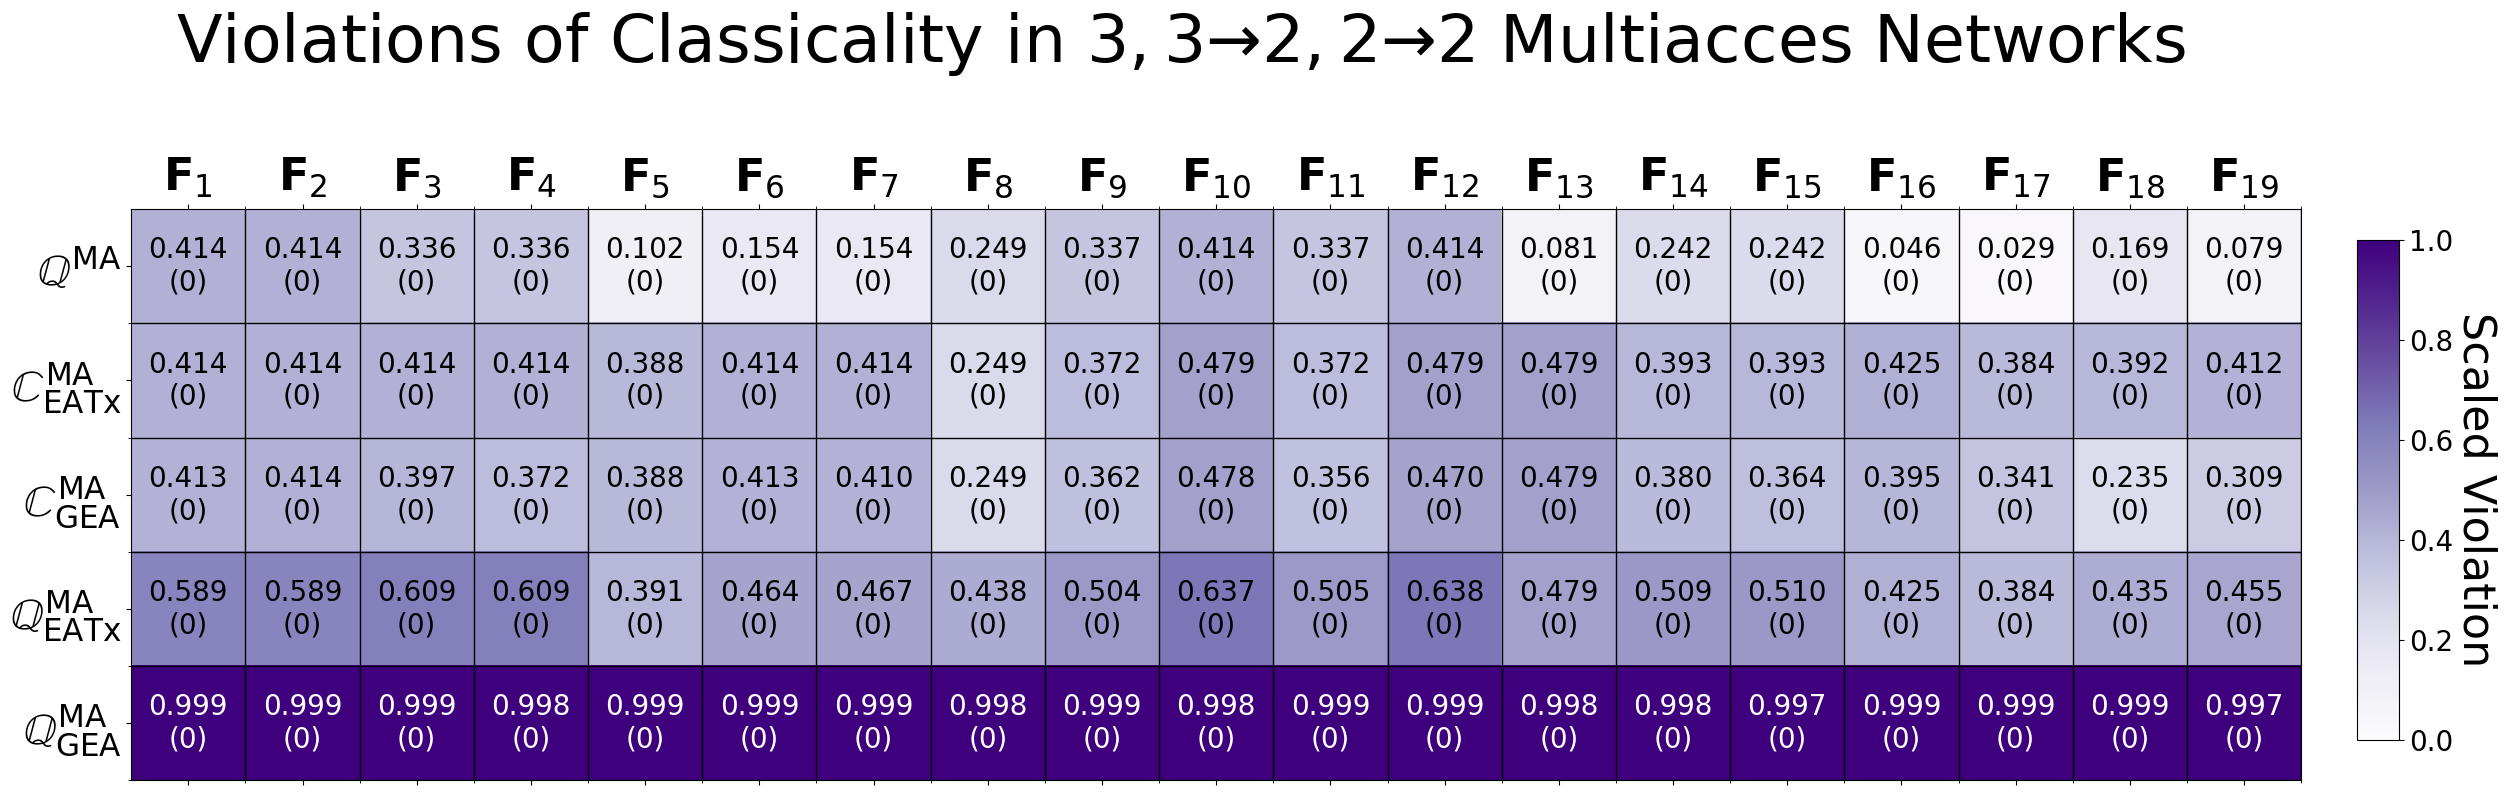

In [45]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(28,10))

fig.suptitle(r"Violations of Classicality in $3,3\to 2,2\to 2$ Multiacces Networks", size=48)

configuration_names = [
    r"$\mathbb{Q}^{\rm{MA}}$",
    r"$\mathbb{C}^{\rm{MA}}_{\rm{EATx}}$",
    r"$\mathbb{C}^{\rm{MA}}_{\rm{GEA}}$",
    r"$\mathbb{Q}^{\rm{MA}}_{\rm{EATx}}$",
    r"$\mathbb{Q}^{\rm{MA}}_{\rm{GEA}}$",
]
game_names = [
    r"$\mathbf{F}_1$", r"$\mathbf{F}_2$",r"$\mathbf{F}_3$", r"$\mathbf{F}_4$", r"$\mathbf{F}_5$", r"$\mathbf{F}_6$", r"$\mathbf{F}_7$", r"$\mathbf{F}_8$", r"$\mathbf{F}_9$", r"$\mathbf{F}_{10}$",
    r"$\mathbf{F}_{11}$", r"$\mathbf{F}_{12}$",r"$\mathbf{F}_{13}$", r"$\mathbf{F}_{14}$", r"$\mathbf{F}_{15}$", r"$\mathbf{F}_{16}$", r"$\mathbf{F}_{17}$", r"$\mathbf{F}_{18}$", r"$\mathbf{F}_{19}$",
]


cc_table_data = np.array(list(map(
    lambda row: [0] * len(game_names),
    configuration_names
)))
violation_table_data = np.array([
    qmac_xor_max_violations[1:],
    ea_mac_xor_max_violations[1:],
    ea3_cmac_xor_max_violations[1:],
    ea_qmac_xor_max_violations[1:],
    ea3_qmac_xor_max_violations[1:],
])


# color bar and plotting colored data
color_map_name = "Purples"
pcm = ax.matshow(violation_table_data, cmap=mpl.colormaps[color_map_name], vmax=1, vmin=0)


# y_tick_labels = configuration_names
x_tick_labels = game_names


ax.set_yticks([y + 0.5 for y in range(0, 5)], minor=True)

ax.set_xticks([x + 0.5 for x in range(0, 19)], minor=True)
ax.set_xticks([x for x in range(0, 19)], minor=False)
ax.grid(which="minor", ls="-", lw=1, color="black")
ax.set_xticklabels(game_names, fontsize=32)


ax.set_yticklabels([""] + configuration_names, fontsize=32)

mat_num_font=20
text_color_threshold = 0.65

import decimal
decimal.getcontext().rounding = decimal.ROUND_DOWN
n_decimals = 3

for y in range(len(cc_table_data)):
    for x in range(len(cc_table_data[0])):

        cc_val = cc_table_data[y][x]
        violation_val = violation_table_data[y][x]

        text_color = "white" if violation_val >= text_color_threshold else "black"

        ax.text(x, y, str(round(decimal.Decimal(violation_val), n_decimals)) + "\n(" + str(int(cc_val)) + ")",
        # qc_ax.text(x, y, '%.3f' % qc_val + "\n" + "(" + str(int(cc_val)) + ")",
            horizontalalignment='center',
            verticalalignment='center',
            size=mat_num_font,
            color=text_color
        )
       


cb_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(pcm, cax=cb_ax)
cbar.ax.set_ylabel('Scaled Violation', rotation=270, size=32, labelpad=32)
cbar.ax.tick_params(labelsize=mat_num_font)



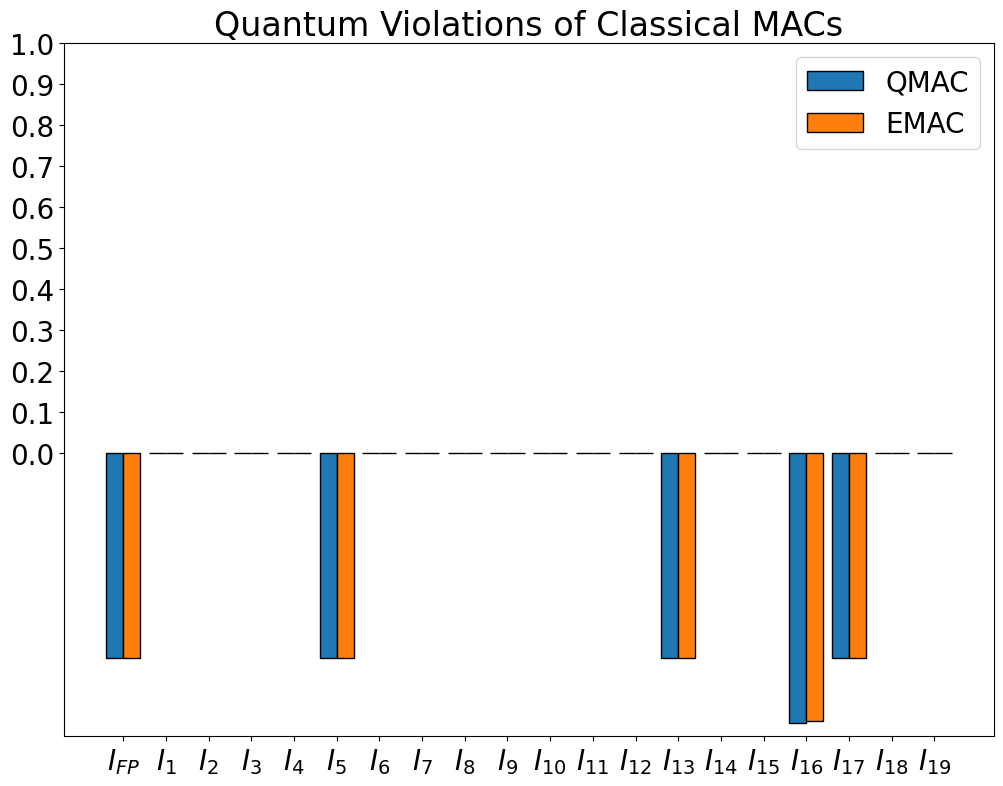

In [10]:
x_labels = [
    r"$I_{FP}$", r"$I_1$", r"$I_2$",r"$I_3$", r"$I_4$", r"$I_5$", r"$I_6$", r"$I_7$", r"$I_8$", r"$I_9$", r"$I_{10}$",
    r"$I_{11}$", r"$I_{12}$",r"$I_{13}$", r"$I_{14}$", r"$I_{15}$", r"$I_{16}$", r"$I_{17}$", r"$I_{18}$", r"$I_{19}$",
]

x_axis = np.arange(20)

plt.figure(figsize=(12, 9))

plt.bar(x_axis-0.2, qmac_and_max_violations, width=0.4, label="QMAC", edgecolor="black")
plt.bar(x_axis+0.2, ea_mac_and_max_violations, width=0.4, label="EMAC", edgecolor="black")

plt.xticks(x_axis, x_labels, fontsize=20)
plt.title("Quantum Violations of Classical MACs", size=24)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize=20)
plt.legend(fontsize=20)

plt.show()

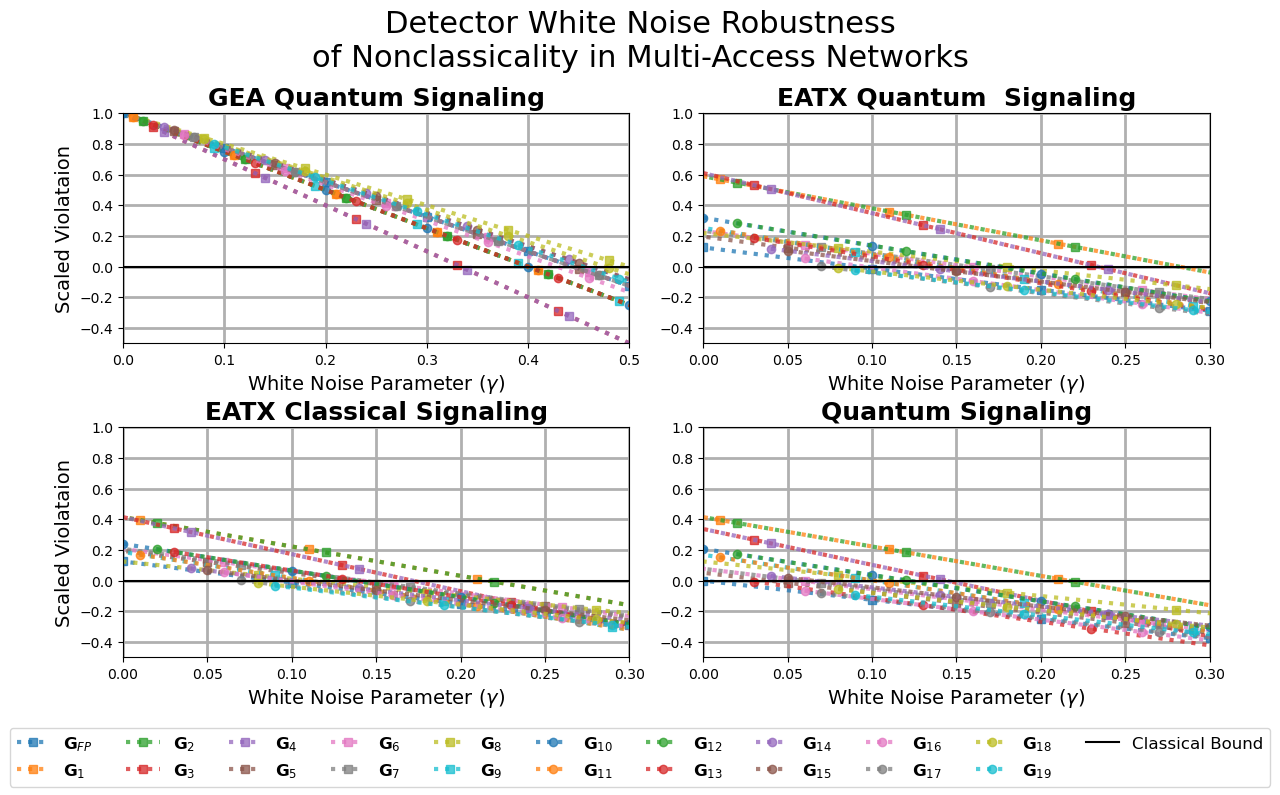

In [9]:
fig, ((ax1, ax3), (ax4, ax2)) = plt.subplots(figsize=(12, 8), nrows=2, ncols=2, constrained_layout=True)
nrange = np.arange(-0.1, 1.001,0.1)
x_labels = [
    r"$\mathbf{G}_{FP}$", r"$\mathbf{G}_1$", r"$\mathbf{G}_2$",r"$\mathbf{G}_3$", r"$\mathbf{G}_4$", r"$\mathbf{G}_5$", r"$\mathbf{G}_6$", r"$\mathbf{G}_7$", r"$\mathbf{G}_8$", r"$\mathbf{G}_9$", r"$\mathbf{G}_{10}$",
    r"$\mathbf{G}_{11}$", r"$\mathbf{G}_{12}$",r"$\mathbf{G}_{13}$", r"$\mathbf{G}_{14}$", r"$\mathbf{G}_{15}$", r"$\mathbf{G}_{16}$", r"$\mathbf{G}_{17}$", r"$\mathbf{G}_{18}$", r"$\mathbf{G}_{19}$",
]


ax1.grid(linewidth=2)
ax2.grid(linewidth=2)
ax3.grid(linewidth=2)
ax4.grid(linewidth=2)

qbounds = quantum_bounds()
wn_scores = white_noise_scores()

for i in range(20):

    linestyle = ":"
    marker = "o" if 9 < i else "s"

    shift = i*0.01

    curve1 = list(map(lambda x: ((1-(x + shift)) * qbounds[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax1.plot(nrange + shift, curve1, linewidth=3, label=x_labels[i], linestyle=linestyle, alpha=0.75, marker=marker)

    curve2 = list(map(lambda x: ((1-(x + shift)) * qmac_xor_max_violations[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax2.plot(nrange + shift, curve2, linewidth=3, linestyle=linestyle, alpha=0.75, marker=marker)

    curve3 = list(map(lambda x: ((1-(x + shift)) * ea_qmac_xor_max_violations[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax3.plot(nrange + shift, curve3, linewidth=3, linestyle=linestyle, alpha=0.75, marker=marker)

    curve4 = list(map(lambda x: ((1-(x + shift)) * ea_mac_xor_max_violations[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax4.plot(nrange + shift, curve4, linewidth=3, linestyle=linestyle, alpha=0.75, marker=marker)



ax1.plot(nrange, [0]*len(nrange), color = "black", label="Classical Bound")
ax2.plot(nrange, [0]*len(nrange), color = "black")
ax3.plot(nrange, [0]*len(nrange), color = "black")
ax4.plot(nrange, [0]*len(nrange), color = "black")

ax1.set_xlim([0,0.5])
ax2.set_xlim([0,0.3])
ax3.set_xlim([0,0.3])
ax4.set_xlim([0,0.3])


ax1.set_ylabel("Scaled Violataion", size=14)
ax4.set_ylabel("Scaled Violataion", size=14)

ax1.set_xlabel(r"White Noise Parameter ($\gamma$)", size=14)
ax2.set_xlabel(r"White Noise Parameter ($\gamma$)", size=14)
ax3.set_xlabel(r"White Noise Parameter ($\gamma$)", size=14)
ax4.set_xlabel(r"White Noise Parameter ($\gamma$)", size=14)

ax1.set_ylim([-0.5,1])
ax2.set_ylim([-0.5,1])
ax3.set_ylim([-0.5,1])
ax4.set_ylim([-0.5,1])

ax1.set_title("GEA Quantum Signaling", size=18, fontweight="bold")
ax2.set_title("Quantum Signaling", size=18, fontweight="bold")
ax3.set_title("EATX Quantum  Signaling", size=18, fontweight="bold")
ax4.set_title("EATX Classical Signaling", size=18, fontweight="bold")



fig.suptitle("Detector White Noise Robustness\nof Nonclassicality in Multi-Access Networks", size=22)

fig.tight_layout()

fig.legend(ncol=11, loc="lower center", fontsize=12)

fig.subplots_adjust(bottom=0.17)

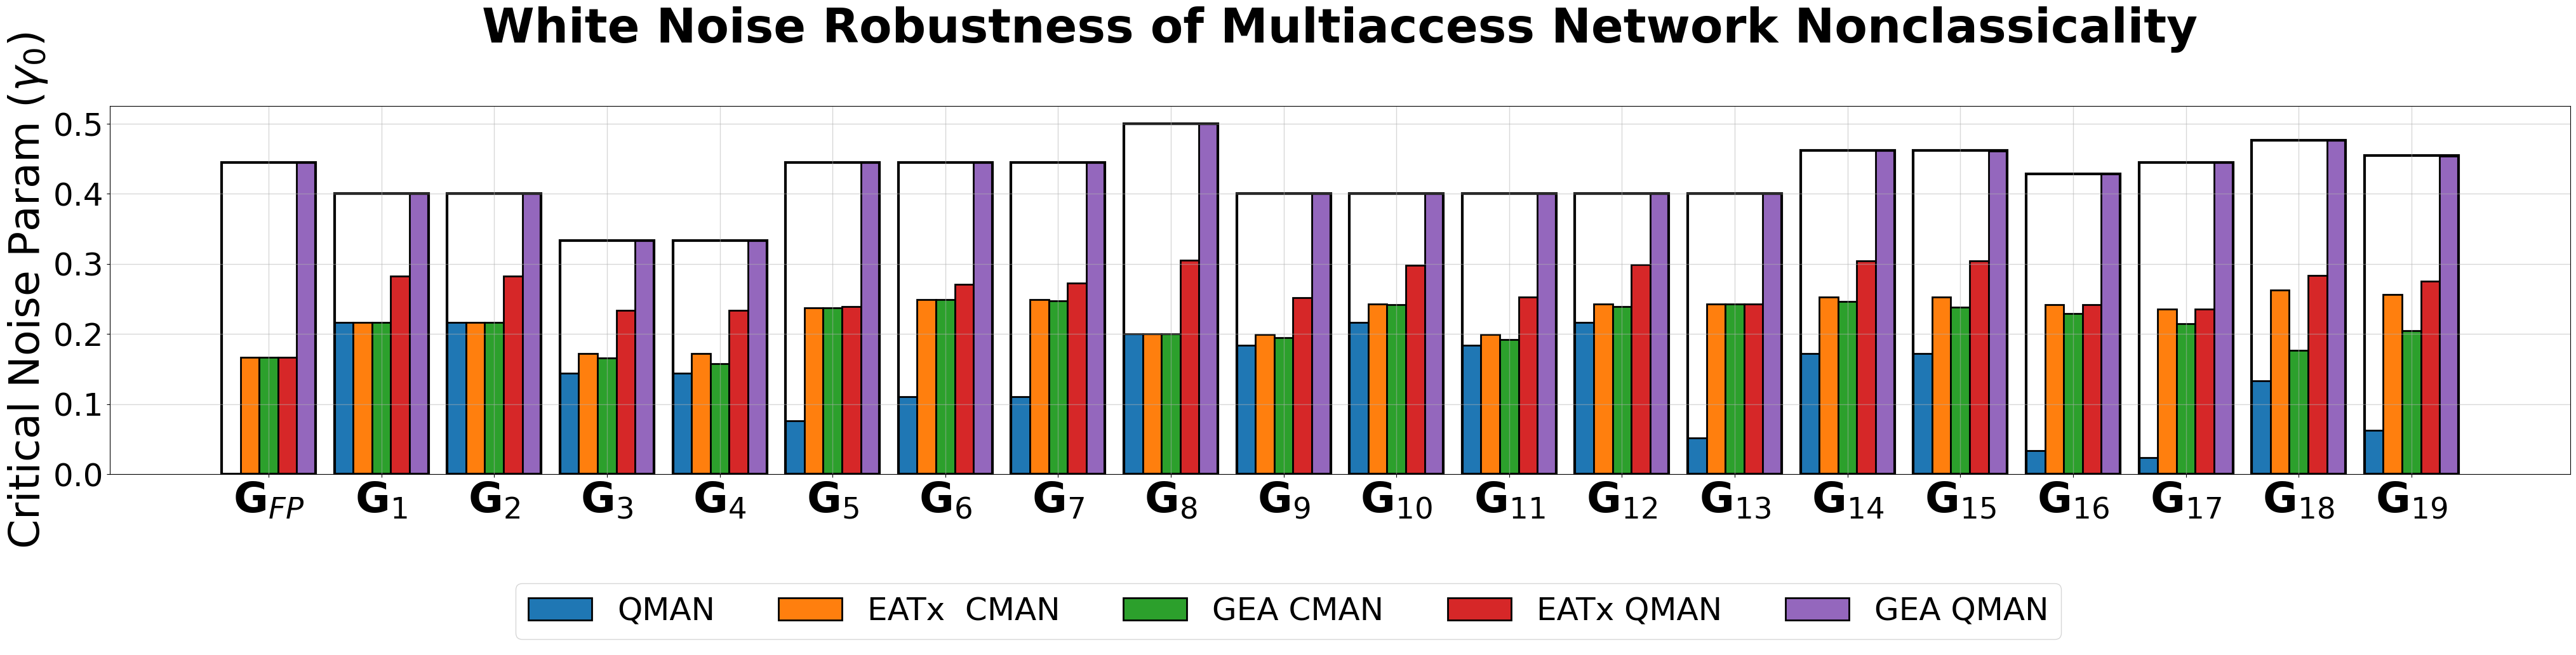

In [10]:
x_labels = [
    r"$\mathbf{G}_{FP}$", r"$\mathbf{G}_1$", r"$\mathbf{G}_2$",r"$\mathbf{G}_3$", r"$\mathbf{G}_4$", r"$\mathbf{G}_5$", r"$\mathbf{G}_6$", r"$\mathbf{G}_7$", r"$\mathbf{G}_8$", r"$\mathbf{G}_9$", r"$\mathbf{G}_{10}$",
    r"$\mathbf{G}_{11}$", r"$\mathbf{G}_{12}$",r"$\mathbf{G}_{13}$", r"$\mathbf{G}_{14}$", r"$\mathbf{G}_{15}$", r"$\mathbf{G}_{16}$", r"$\mathbf{G}_{17}$", r"$\mathbf{G}_{18}$", r"$\mathbf{G}_{19}$",
]

x_axis = np.arange(20)

width = 1/6

fig = plt.figure(figsize=(50, 10))
plt.grid(linewidth=1, alpha=0.5)


plt.bar(x_axis-2*width, mac_critical_params(qmac_xor_max_violations), width=width, label="QMAN", edgecolor="black",linewidth=2)
plt.bar(x_axis-1*width, mac_critical_params(ea_mac_xor_max_violations), width=width, label="EATx  CMAN", edgecolor="black", linewidth=2)
plt.bar(x_axis+0*width, mac_critical_params(ea3_cmac_xor_max_violations), width=width, label="GEA CMAN", edgecolor="black", linewidth=2)
plt.bar(x_axis+1*width, mac_critical_params(ea_qmac_xor_max_violations), width=width, label="EATx QMAN", edgecolor="black", linewidth=2)

# plt.bar(x_axis+3*width, ghza_qmac_xor_max_violations, width=width, label="GHZA QMAC", edgecolor="black", linewidth=2)
# plt.bar(x_axis+4*width, ea_txrx_xor_max_violations, width=width, label="EA TxRx CMAC", edgecolor="black", linewidth=2)
plt.bar(x_axis+2*width, mac_critical_params(ea3_qmac_xor_max_violations), width=width, label="GEA QMAN", edgecolor="black", linewidth=2)
# plt.bar(x_axis+6*width, ghza_cmac_xor_max_violations, width=width, label="GHZA CMAC", edgecolor="black", linewidth=2)
# plt.bar(x_axis+7*width, ghza_cmac_no_locc_xor_max_violations, width=width, label="GHZA CMAC No LOCC", edgecolor="black", linewidth=2)




# plt.bar(x_axis+1*width, quantum_bounds(), width=1-width,  label="Violation Bound", edgecolor="black", linewidth=3, fill=False)
plt.bar(x_axis+0*width, mac_critical_params(np.ones(20)), width=1-width, edgecolor="black", linewidth=3, fill=False)





plt.xticks(x_axis, x_labels, fontsize=48)
plt.title("White Noise Robustness of Multiaccess Network Nonclassicality\n", size=54, fontweight="bold")
plt.yticks(fontsize=36)
plt.ylabel(r"Critical Noise Param ($\gamma_0$)", fontsize=48)
# plt.legend(fontsize=20, ncol=3)

plt.figlegend(loc="lower center", ncols = 6, fontsize=36)
plt.subplots_adjust(bottom=0.3)

plt.show()

## Sig Dim Data Analysis

In [5]:
data_path = "../data/qubit_signaling_dimension/"

eacc_ry_encoder_opt_dicts = get_sig_dim_opt_dicts(data_path, r"^(eacc_ry_encoder_|ghzacc_ry_encoder_)")
# eacc_ghz_ry_arb_opt_dicts = get_sig_dim_opt_dicts(data_path, r"^ghzacc_ry_encoder_")
eaqc_arb_encoder_opt_dicts = get_sig_dim_opt_dicts(data_path, r"^(eaqc_arb_|eaqc_ghz_arb_arb_|eaqc_ghz_arb_arb_)")
# eaqc_ghz_arb_arb_opt_dicts = get_sig_dim_opt_dicts(data_path, r"^eaqc_ghz_arb_arb_")
# eaqc_ghz_ryrz_arb_opt_dicts = get_sig_dim_opt_dicts(data_path, r"^eaqc_ghz_arb_arb_")

In [6]:
def analyze_sig_dim_data(inequality_opt_dicts):
    sig_dim_inequalities = mac.qubit_signaling_dimension_bounds()
    classical_bounds = [inequality_tuple[0] for inequality_tuple in sig_dim_inequalities]
    game_bounds = game_sig_dim_max_violations()


    max_violations = []
    for i in range(len(sig_dim_inequalities)):
        max_violations += [
            (max([max(opt_dict["scores"]) for opt_dict in inequality_opt_dicts[i]]) - classical_bounds[i])  / game_bounds[i]
        ]

    return max_violations

def game_sig_dim_max_violations():
    sig_dim_inequalities = mac.qubit_signaling_dimension_bounds()
    classical_bounds = [inequality_tuple[0] for inequality_tuple in sig_dim_inequalities]
    game_max_bounds = [sum([np.max(inequality[1][:,x]) for x in range(inequality[1].shape[1])]) for inequality in sig_dim_inequalities]

    return [
        game_max_bounds[i] - classical_bounds[i]
        for i in range(len(sig_dim_inequalities))
    ]


def white_noise_sig_dim_scores():
    sig_dim_inequalities = mac.qubit_signaling_dimension_bounds()
    classical_bounds = [inequality_tuple[0] for inequality_tuple in sig_dim_inequalities]
    # max_game_bounds = game_sig_dim_max_violations()

    wn_scores = [(np.sum(sig_dim_inequalities[i][1])/4 - classical_bounds[i]) for i in range(len(classical_bounds))]
    return wn_scores

def sig_dim_critical_params(max_violations):
    wn_scores = white_noise_sig_dim_scores()
    qbounds = game_sig_dim_max_violations()

    critical_params = []
    for i in range(8):
        gamma = max_violations[i] / (max_violations[i] - wn_scores[i] / qbounds[i])
        critical_params += [gamma]

    return critical_params



# def game_sig_dim_white_noise_scores():
#     sig_dim_inequalities = mac.qubit_signaling_dimension_bounds()
#     classical_bounds = [inequality_tuple[0] for inequality_tuple in sig_dim_inequalities]
#     game_min_scores = [sum([np.sum(inequality[1][:,x]) for x in range(inequality[1].shape[1])])/inequality.shape[0] for inequality in sig_dim_inequalities]

#     return [
#         game_max_bounds[i] - classical_bounds[i]
#         for i in range(len(sig_dim_inequalities))
#     ]


game_bounds = game_sig_dim_max_violations()


eacc_ry_encoder_max_violations = analyze_sig_dim_data(eacc_ry_encoder_opt_dicts)
# eacc_ghz_ry_arb_max_violations = analyze_sig_dim_data(eacc_ghz_ry_arb_opt_dicts)
eaqc_arb_encoder_max_violations = analyze_sig_dim_data(eaqc_arb_encoder_opt_dicts)
# eaqc_ghz_arb_arb_max_violations = analyze_sig_dim_data(eaqc_ghz_arb_arb_opt_dicts)
# eaqc_ghz_ryrz_arb_max_violations = analyze_sig_dim_data(eaqc_ghz_ryrz_arb_opt_dicts)

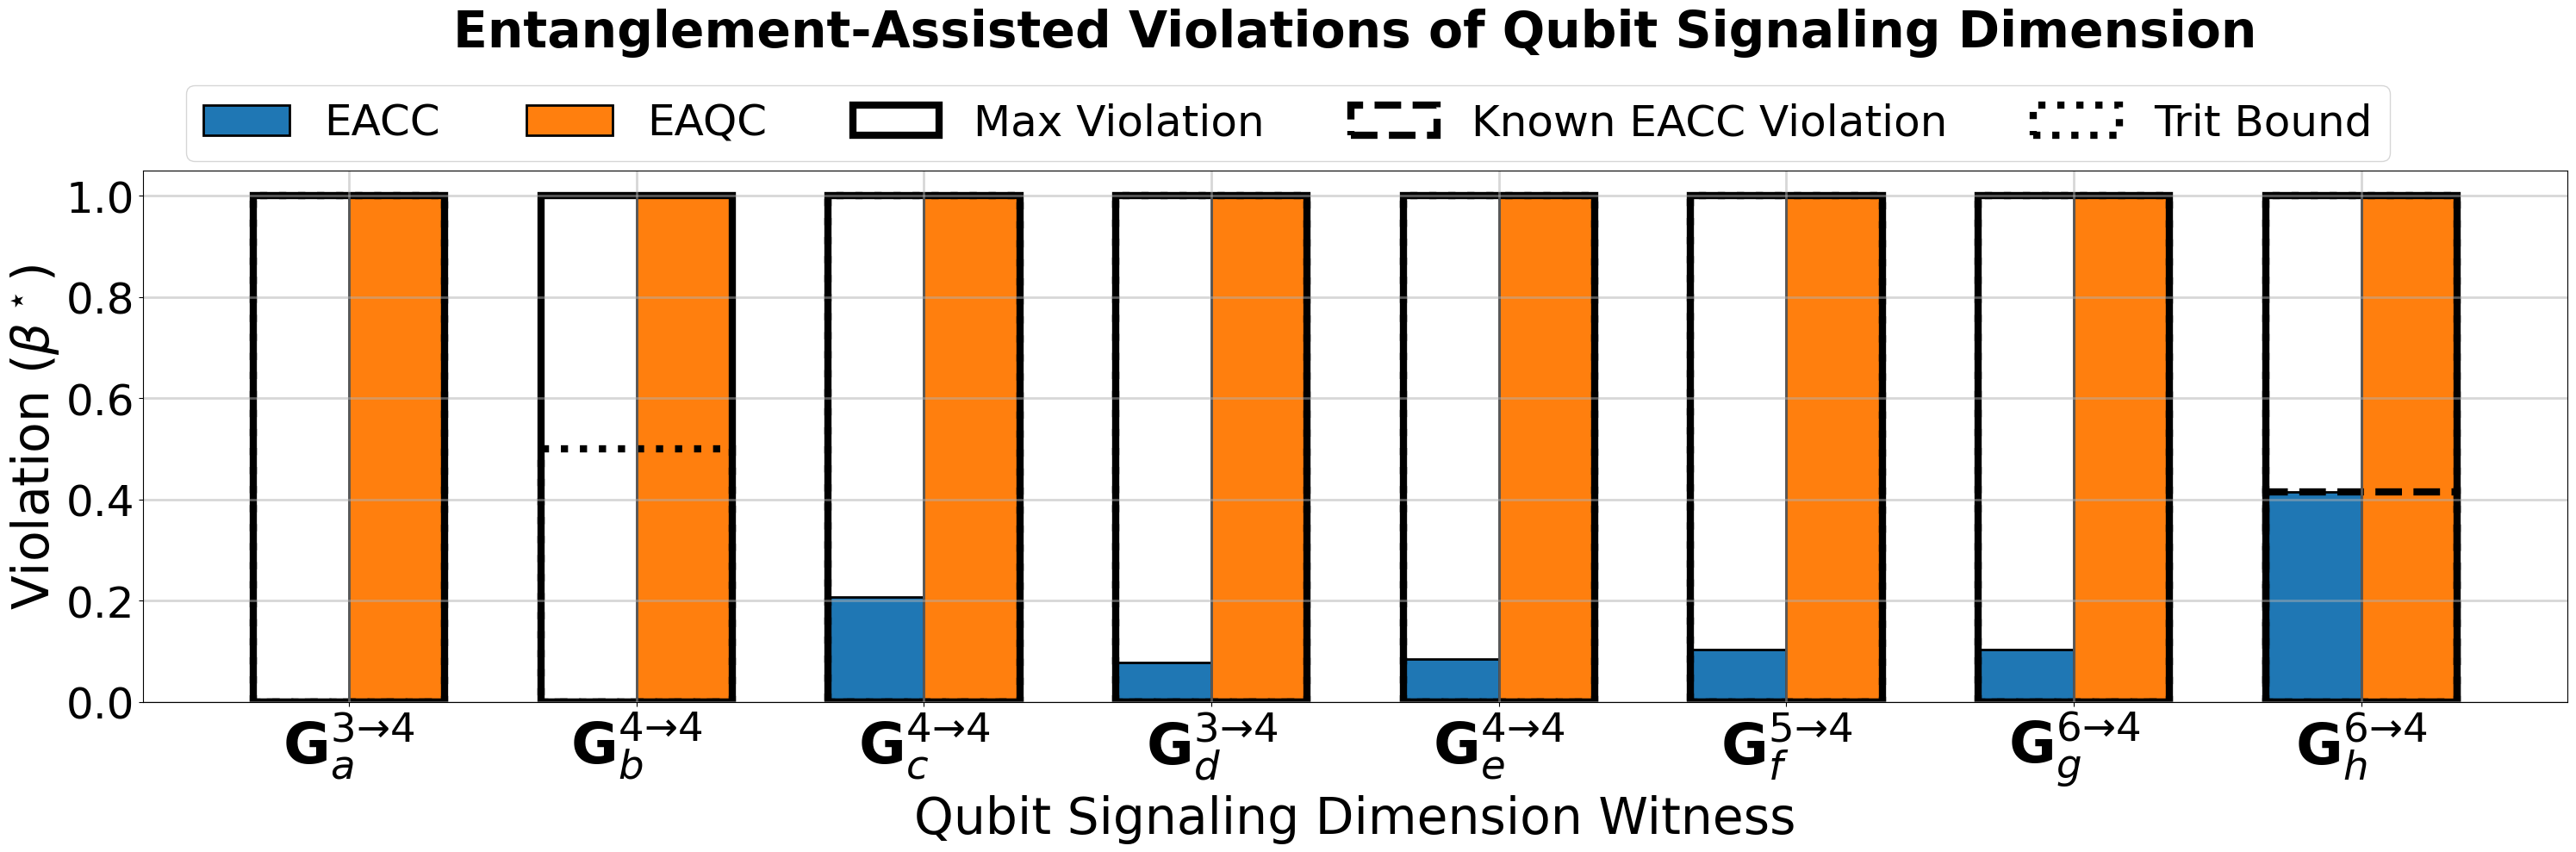

In [15]:
x_labels = [
    r"$\mathbf{G}_{a}^{3\to 4}$", r"$\mathbf{G}_b^{4\to 4}$", r"$\mathbf{G}_c^{4\to 4}$",r"$\mathbf{G}_d^{3 \to 4}$", r"$\mathbf{G}_e^{4 \to 4}$", r"$\mathbf{G}_f^{5 \to 4}$", r"$\mathbf{G}_g^{6\to 4}$", r"$\mathbf{G}_h^{6 \to 4}$",
]

x_axis = np.arange(8)

width = 1/3

fig = plt.figure(figsize=(30, 10))
plt.grid(linewidth=2, alpha=0.5)


plt.bar(x_axis-0.5*width, eacc_ry_encoder_max_violations, width=width, label="EACC", edgecolor="black",linewidth=2)
plt.bar(x_axis+0.5*width, eaqc_arb_encoder_max_violations, width=width, label="EAQC", edgecolor="black", linewidth=2)



# plt.bar(x_axis+1*width, eacc_ghz_ry_arb_max_violations, width=width, label="EACC GHZ State", edgecolor="black", linewidth=2)
# plt.bar(x_axis+2*width, eaqc_arb_encoder_max_violations, width=width, label="EAQC Arb State", edgecolor="black", linewidth=2)
# plt.bar(x_axis+3*width, eaqc_ghz_arb_arb_max_violations, width=width, label="EAQC GHZ Arb Arb", edgecolor="black", linewidth=2)
# plt.bar(x_axis+4*width, eaqc_ghz_ryrz_arb_max_violations, width=width, label="EAQC GHZ RYRZ Arb", edgecolor="black", linewidth=2)



trit_max_bounds = [1,0.5,1,1,1,1,1,1]

eacc_max_bounds = [0,0,0,0,0,0,0,
    # ((5 + np.sqrt(2))/2 - 3),
    # ((7 + np.sqrt(2))/2 - 4)/2,
    # ((7 + np.sqrt(2))/2 - 4)/2,
    # ((7 + np.sqrt(2))/2 - 4)/2,
    # ((7 + np.sqrt(2))/2 - 4)/2,
    ((4 + np.sqrt(2)) - 5)
]
plt.bar(x_axis+0*width, np.ones(8), width=1-width,  label="Max Violation", edgecolor="black", linewidth=6, fill=False)

plt.bar(x_axis+0*width, eacc_max_bounds, width=1-width,  label="Known EACC Violation", edgecolor="black", linewidth=6, fill=False, linestyle="--")
plt.bar(x_axis+0*width, trit_max_bounds, width=1-width,  label="Trit Bound", edgecolor="black", linewidth=6, fill=False, linestyle=":")



plt.xticks(x_axis, x_labels, fontsize=48)
plt.title("Entanglement-Assisted Violations of Qubit Signaling Dimension\n\n", size=42, fontweight="bold")
plt.yticks(fontsize=36)
fig.legend(fontsize=36, ncol=5, loc="upper center", bbox_to_anchor=(0.5,0.92))
plt.ylabel(r"Violation ($\beta^\star$)", fontsize=42)
plt.xlabel("Qubit Signaling Dimension Witness", fontsize=42)

fig.tight_layout()


plt.show()

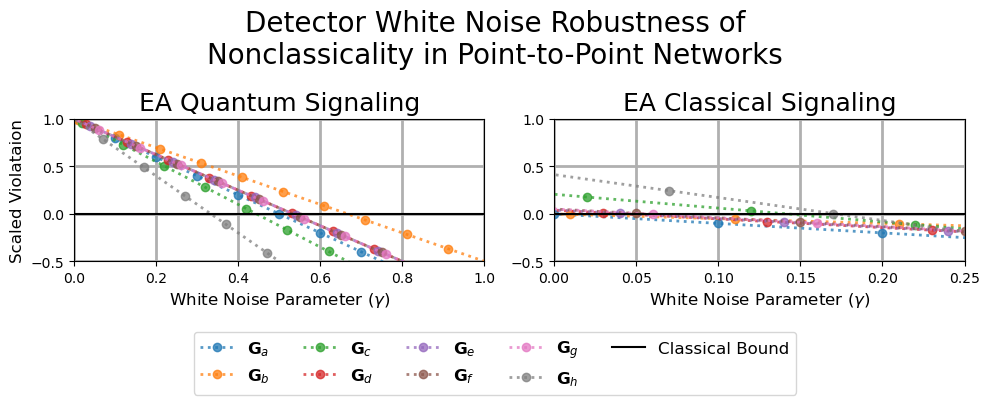

In [169]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
nrange = np.arange(-0.1, 1.001,0.1)
x_labels = [
    r"$\mathbf{G}_{a}$", r"$\mathbf{G}_b$", r"$\mathbf{G}_c$",r"$\mathbf{G}_d$", r"$\mathbf{G}_e$", r"$\mathbf{G}_f$", r"$\mathbf{G}_g$", r"$\mathbf{G}_h$",
]


ax1.grid(linewidth=2)
ax2.grid(linewidth=2)


qbounds = game_sig_dim_max_violations()
wn_scores = white_noise_sig_dim_scores()


for i in range(8):

    linestyle = ":"
    marker = "o" 

    shift = i*0.01

    curve1 = list(map(lambda x: ((1-(x + shift)) * qbounds[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax1.plot(nrange + shift, curve1, linewidth=2, label=x_labels[i], linestyle=linestyle, alpha=0.75, marker=marker)

    curve2 = list(map(lambda x: ((1-(x + shift)) * eacc_ry_encoder_max_violations[i] + (x + shift) * wn_scores[i])/qbounds[i], nrange))
    ax2.plot(nrange + shift, curve2, linewidth=2, linestyle=linestyle, alpha=0.75, marker=marker)



ax1.plot(nrange, [0]*len(nrange), color = "black", label="Classical Bound")
ax2.plot(nrange, [0]*len(nrange), color = "black")

ax1.set_xlim([0,1])
ax2.set_xlim([0,0.25])


ax1.set_ylabel("Scaled Violataion", size=12)
ax1.set_xlabel(r"White Noise Parameter ($\gamma$)", size=12)
ax2.set_xlabel(r"White Noise Parameter ($\gamma$)", size=12)


ax1.set_ylim([-0.5,1])
ax2.set_ylim([-0.5,1])

ax1.set_title("EA Quantum Signaling", size=18)
ax2.set_title("EA Classical Signaling", size=18)


fig.suptitle("Detector White Noise Robustness of\nNonclassicality in Point-to-Point Networks", size=20)

fig.tight_layout()

fig.legend(ncol=5, loc="lower center", fontsize=12)

fig.subplots_adjust(bottom=0.35)


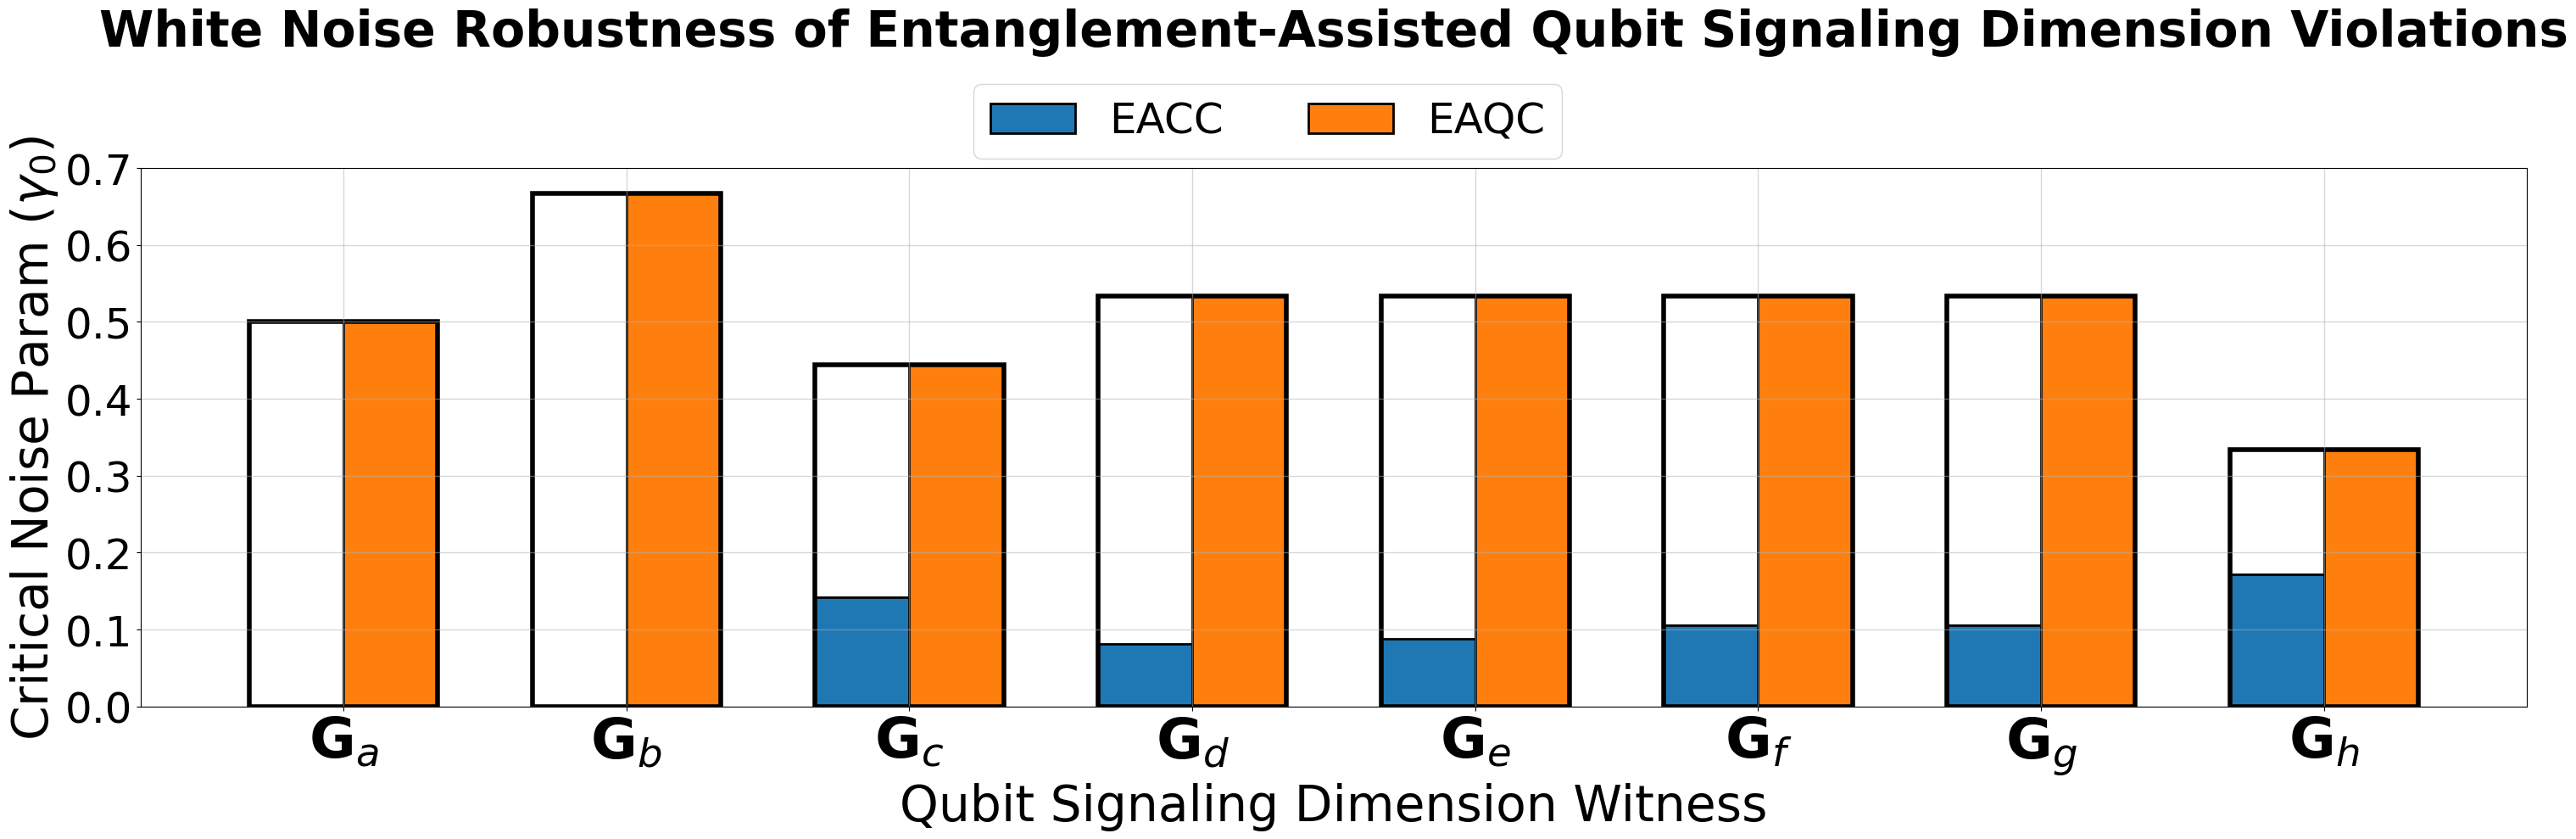

In [171]:
x_labels = [
    r"$\mathbf{G}_{a}$", r"$\mathbf{G}_b$", r"$\mathbf{G}_c$",r"$\mathbf{G}_d$", r"$\mathbf{G}_e$", r"$\mathbf{G}_f$", r"$\mathbf{G}_g$", r"$\mathbf{G}_h$",
]

x_axis = np.arange(8)

width = 1/3

fig = plt.figure(figsize=(30, 10))
plt.grid(linewidth=1, alpha=0.5)


plt.bar(x_axis-0.5*width, sig_dim_critical_params(eacc_ry_encoder_max_violations), width=width, label="EACC", edgecolor="black",linewidth=2)
plt.bar(x_axis+0.5*width, sig_dim_critical_params(eaqc_arb_encoder_max_violations), width=width, label="EAQC", edgecolor="black", linewidth=2)



# plt.bar(x_axis+1*width, eacc_ghz_ry_arb_max_violations, width=width, label="EACC GHZ State", edgecolor="black", linewidth=2)
# plt.bar(x_axis+2*width, eaqc_arb_encoder_max_violations, width=width, label="EAQC Arb State", edgecolor="black", linewidth=2)
# plt.bar(x_axis+3*width, eaqc_ghz_arb_arb_max_violations, width=width, label="EAQC GHZ Arb Arb", edgecolor="black", linewidth=2)
# plt.bar(x_axis+4*width, eaqc_ghz_ryrz_arb_max_violations, width=width, label="EAQC GHZ RYRZ Arb", edgecolor="black", linewidth=2)





# eacc_max_bounds = [0,0,
#     ((5 + np.sqrt(2))/2 - 3),
#     ((7 + np.sqrt(2))/2 - 4)/2,
#     ((7 + np.sqrt(2))/2 - 4)/2,
#     ((7 + np.sqrt(2))/2 - 4)/2,
#     ((7 + np.sqrt(2))/2 - 4)/2,
#     ((4 + np.sqrt(2)) - 5)
# ]
# plt.bar(x_axis+0*width, eacc_max_bounds, width=1-width,  label="EACC Bound", edgecolor="black", linewidth=4, fill=False, linestyle="--")
plt.bar(x_axis+0*width, sig_dim_critical_params(np.ones(8)), width=1-width, edgecolor="black", linewidth=4, fill=False)


plt.xticks(x_axis, x_labels, fontsize=48)
plt.title("White Noise Robustness of Entanglement-Assisted Qubit Signaling Dimension Violations\n\n", size=42, fontweight="bold")
plt.yticks(fontsize=36)
fig.legend(fontsize=36, ncol=4, loc="upper center", bbox_to_anchor=(0.5,0.92))
plt.ylabel(r"Critical Noise Param ($\gamma_0$)", fontsize=42)
plt.xlabel("Qubit Signaling Dimension Witness", fontsize=42)

fig.tight_layout()


plt.show()

In [172]:
[1,2,3,4] / [4,5,6,7]

TypeError: unsupported operand type(s) for /: 'list' and 'list'